In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.core.lightning import LightningModule


from tqdm import tqdm

In [3]:
import sys
sys.path.append('../')

from dl4time.data.databuilder import StockDataset, StockData, StockData_ensemble
from dl4time.data.preprocessing import MinMaxTransformation, NormalizationCurrentDay

from dl4time.model.Conv import Conv1D
from dl4time.model.RNN import RNN
from dl4time.model.lighting import Model

from dl4time.utils.evaluation import Evaluator

In [21]:
class Model(LightningModule):
    def __init__(self, model):
        super().__init__()
        
        self.save_hyperparameters()
        
        self.model = model

    def forward(self, x):
        return self.model(x)
    
    def train_dataloader(self):
        params = {'batch_size': 256,
                  'shuffle': True,
                  'num_workers': 6}
        
        train_dataset = StockDataset(data_all.data['x_train'], data_all.data['y_train'])
        
        return DataLoader(train_dataset, **params)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)
    
#     def mse_loss(self):
#         loss = torch.nn.MSELoss(size_average=True)
#         return loss
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.mse_loss(logits, y)
        # add logging
        logs = {'loss': loss}
        return {'loss': loss, 'log': logs}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.mse_loss(logits, y)
        return {'val_loss': loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'val_loss': avg_loss, 'log': tensorboard_logs}

    def val_dataloader(self):
        params = {'batch_size': 256,
                  'shuffle': False,
                  'num_workers': 6}
        
        val_dataset = StockDataset(data_all.data['x_val'], data_all.data['y_val'])
        return DataLoader(val_dataset, **params)
        
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.mse_loss(logits, y)
        return {'val_loss': loss}

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'test_loss': avg_loss}
        return {'test_loss': avg_loss, 'log': tensorboard_logs}

    def test_dataloader(self):
        params = {'batch_size': 256,
                  'shuffle': False,
                  'num_workers': 6}
        
        test_dataset = StockDataset(data_all.data['x_test'], data_all.data['y_test'])
        return DataLoader(test_dataset, **params)

In [4]:
dates = pd.date_range('2000-01-02','2017-10-11',freq='B')
data_all = StockData('aapl', dates, transformation=NormalizationCurrentDay())

In [5]:
data_all.data['x_train'].shape

(3088, 60, 1)

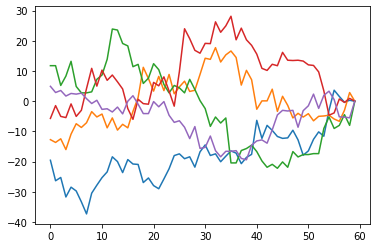

In [6]:
plt.plot(data_all.data['x_train'][0,:,:])
plt.plot(data_all.data['x_train'][100,:,:])
plt.plot(data_all.data['x_train'][200,:,:])
plt.plot(data_all.data['x_train'][300,:,:])
plt.plot(data_all.data['x_train'][400,:,:])
plt.show()

In [7]:
# import os
# symbols = [name.split(".")[0] for name in os.listdir("../Data_Folder/Stocks")]
# symbols.sort()

# dates = pd.date_range('2000-01-02','2017-10-11',freq='B')
# data_all = StockData_ensemble(symbols, dates, transformation=NormalizationCurrentDay(), max_num=2000)

# print(data_all.data['y_test'].shape)
# print(data_all.data['x_test'].shape)

In [8]:
import pickle
with open('../Data_Folder/Stocks_all.pickle', 'rb') as f:
    data_container = pickle.load(f)

import pickle
with open('../Data_Folder/Stocks_all.pickle', 'wb') as f:
    pickle.dump(data_all, f) 

In [9]:
dataloader_params = {'batch_size': 1024,
                     'num_workers': 2}

net = RNN(input_dim=1, hidden_dim=128, num_layers=3, output_dim=1)
model_lstm = Model(net, data_all, dataloader_params=dataloader_params)
dl = model_lstm.train_dataloader()

/home/shun/Desktop/projects/DLforTime/venv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: `train_dataloader` must be implemented to be used with the Lightning Trainer
  warnings.warn(*args, **kwargs)


In [22]:
%lprun
dataloader_params = {'batch_size': 1024,
                     'num_workers': 2}

net = RNN(input_dim=1, hidden_dim=128, num_layers=3, output_dim=1)
model_lstm = Model(net)



In [11]:
train_dataset = StockDataset(data_container.data['x_train'], data_container.data['y_train'])

train_loader = DataLoader(train_dataset, shuffle=True, **dataloader_params)

In [12]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [13]:
# net.to(device)
# criterion = nn.MSELoss().to(device)
# optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [14]:
# for X, y in tqdm(train_loader):
#     X = X.to(device)
#     y = y.to(device)
    
#     optimizer.zero_grad()
#     y_pred = net(X)
#     loss = criterion(y_pred, y)
#     loss.backward()
#     optimizer.step()

In [23]:

trainer = Trainer(max_epochs=20, gpus=1)
trainer.fit(model_lstm, train_loader)

trainer.test()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | RNN  | 331 K 


Epoch 1:   0%|          | 0/8785 [00:00<?, ?it/s]                     

/home/shun/Desktop/projects/DLforTime/venv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning:

The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Epoch 1: 100%|█████████▉| 8783/8785 [08:31<00:00, 17.18it/s, loss=10.985, v_num=28]  
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|█████████▉| 8783/8785 [08:26<00:00, 17.33it/s, loss=10.356, v_num=28]  
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|█████████▉| 8783/8785 [08:21<00:00, 17.51it/s, loss=10.569, v_num=28]  
Validating: 0it [00:00, ?it/s]
Epoch 4:  75%|███████▍  | 6569/8785 [06:21<02:08, 17.23it/s, loss=11.301, v_num=28] 
Testing: 0it [00:00, ?it/s]

/home/shun/Desktop/projects/DLforTime/venv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning:

Detected KeyboardInterrupt, attempting graceful shutdown...



Testing:  25%|██▌       | 1/4 [00:00<00:01,  2.42it/s]--------------------------------------------------------------------------------
TEST RESULTS
{'test_loss': tensor(1.9740, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 4/4 [00:00<00:00,  6.81it/s]


{'test_loss': 1.9739773273468018}

In [24]:
symbol = "aapl"
stock = StockData(symbol, dates, transformation=NormalizationCurrentDay())
stock.inference(model_lstm)

stock_evaluator = Evaluator()
stock_evaluator.evaluate(pd.Series(stock.y_pred['test'].flatten()), pd.Series(stock.y_true['test'].flatten()))
print(stock_evaluator.metrics)

stock.plot()

/home/shun/Desktop/projects/DLforTime/venv/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



explained variance         -0.000998
MAE                         1.010032
MSE                         2.061038
MedAE                       0.701538
RSQ                        -0.002321
accuracy                   54.029512
edge                             NaN
noise                     874.169800
y_true_chg                       inf
y_pred_chg                468.832794
prediction_calibration      0.000000
capture_ratio                    NaN
edge_long                        NaN
edge_short                       NaN
edge_win                         NaN
edge_lose                        NaN
dtype: float64


In [25]:
symbol = "ibm"
stock = StockData(symbol, dates, transformation=NormalizationCurrentDay())
stock.inference(model_lstm)

stock_evaluator = Evaluator()
stock_evaluator.evaluate(pd.Series(stock.y_pred['test'].flatten()), pd.Series(stock.y_true['test'].flatten()))
print(stock_evaluator.metrics)

stock.plot()

/home/shun/Desktop/projects/DLforTime/venv/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



explained variance         -0.001172
MAE                         0.810970
MSE                         1.347747
MedAE                       0.598306
RSQ                        -0.004870
accuracy                   48.639456
edge                             NaN
noise                     562.889465
y_true_chg                       inf
y_pred_chg                303.305267
prediction_calibration      0.000000
capture_ratio                    NaN
edge_long                        NaN
edge_short                       NaN
edge_win                         NaN
edge_lose                        NaN
dtype: float64


In [27]:
dataloader_params = {'batch_size': 1024,
                     'num_workers': 4}

#net = LSTM(input_dim=1, hidden_dim=64, num_layers=2, output_dim=1)
net2 = Conv1D(in_channels=1, output_dim=1)
model_Conv1D = Model(net2)

trainer = Trainer(max_epochs=50, gpus=1)
trainer.fit(model_Conv1D)

trainer.test()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | Conv1D | 242 K 


Epoch 1:  87%|████████▋ | 13/15 [00:00<00:00, 17.86it/s, loss=8.437, v_num=29]
Validating: 0it [00:00, ?it/s]
Epoch 2:  87%|████████▋ | 13/15 [00:00<00:00, 18.39it/s, loss=7.833, v_num=29]
Validating: 0it [00:00, ?it/s]
Epoch 3:  87%|████████▋ | 13/15 [00:00<00:00, 17.90it/s, loss=7.967, v_num=29]
Validating: 0it [00:00, ?it/s]
Epoch 4:  87%|████████▋ | 13/15 [00:00<00:00, 18.65it/s, loss=8.439, v_num=29]
Validating: 0it [00:00, ?it/s]
Epoch 5:  87%|████████▋ | 13/15 [00:00<00:00, 18.04it/s, loss=7.899, v_num=29]
Validating: 0it [00:00, ?it/s]
Epoch 6:  87%|████████▋ | 13/15 [00:00<00:00, 15.15it/s, loss=8.114, v_num=29]
Validating: 0it [00:00, ?it/s]
Epoch 7:  87%|████████▋ | 13/15 [00:00<00:00, 18.31it/s, loss=8.631, v_num=29]
Validating: 0it [00:00, ?it/s]
Epoch 8:  87%|████████▋ | 13/15 [00:00<00:00, 17.78it/s, loss=8.029, v_num=29]
Validating: 0it [00:00, ?it/s]
Epoch 9:  87%|████████▋ | 13/15 [00:00<00:00, 18.45it/s, loss=7.937, v_num=29]
Validating: 0it [00:00, ?it/s]
Epoch 10: 

Epoch 43:  87%|████████▋ | 13/15 [00:00<00:00, 15.85it/s, loss=8.840, v_num=29]
Validating: 0it [00:00, ?it/s]
Epoch 44:  87%|████████▋ | 13/15 [00:00<00:00, 17.66it/s, loss=8.910, v_num=29]
Validating: 0it [00:00, ?it/s]
Epoch 45:  87%|████████▋ | 13/15 [00:00<00:00, 18.82it/s, loss=7.996, v_num=29]
Validating: 0it [00:00, ?it/s]
Epoch 46:  87%|████████▋ | 13/15 [00:00<00:00, 18.30it/s, loss=8.082, v_num=29]
Validating: 0it [00:00, ?it/s]
Epoch 47:  87%|████████▋ | 13/15 [00:00<00:00, 17.97it/s, loss=8.229, v_num=29]
Validating: 0it [00:00, ?it/s]
Epoch 48:  87%|████████▋ | 13/15 [00:00<00:00, 18.66it/s, loss=8.037, v_num=29]
Validating: 0it [00:00, ?it/s]
Epoch 49:  87%|████████▋ | 13/15 [00:00<00:00, 18.42it/s, loss=7.445, v_num=29]
Validating: 0it [00:00, ?it/s]
Epoch 50:  87%|████████▋ | 13/15 [00:00<00:00, 17.49it/s, loss=8.094, v_num=29]
Validating: 0it [00:00, ?it/s]
Testing:  25%|██▌       | 1/4 [00:00<00:01,  2.52it/s]----------------------------------------------------------

{'test_loss': 2.008073568344116}

In [ ]:
symbol = "aapl"
stock = StockData(symbol, dates, transformation=NormalizationCurrentDay())
stock.inference(model_Conv1D)

stock_evaluator = Evaluator()
stock_evaluator.evaluate(pd.Series(stock.y_pred['test'].flatten()), pd.Series(stock.y_true['test'].flatten()))
print(stock_evaluator.metrics)

stock.plot()

/home/shun/Desktop/projects/DLforTime/venv/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



explained variance         -0.019270
MAE                         1.026550
MSE                         2.096740
MedAE                       0.730451
RSQ                        -0.019684
accuracy                   49.716232
edge                             NaN
noise                     212.279541
y_true_chg                       inf
y_pred_chg                124.328178
prediction_calibration      0.000000
capture_ratio                    NaN
edge_long                        NaN
edge_short                       NaN
edge_win                         NaN
edge_lose                        NaN
dtype: float64


In [ ]:
symbol = "ibm"
stock = StockData(symbol, dates, transformation=NormalizedTransformation())
stock.inference(model_Conv1D)

stock_evaluator = Evaluator()
stock_evaluator.evaluate(pd.Series(stock.y_pred['test'].flatten()), pd.Series(stock.y_true['test'].flatten()))
print(stock_evaluator.metrics)

stock.plot()